In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import pprint
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import cross_val_score,cross_validate
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn import set_config



In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv") 

In [3]:
# get glucose median for the target variable
p50 = df['avg_glucose_level'].median()
df['median_glucose'] = df['avg_glucose_level'].apply(lambda x: 1 if x< p50 else 0 )

In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,median_glucose
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,0
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,0
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,0
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,0
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,0


#  Missing values 
- In the last workbook we removed rows with missing values
- Let's try to impute the values instead. Generally we want to keep as much as the training rows as possible
- We will have correct each columns with missing data individually

In [5]:
print(df['bmi'].isnull().value_counts())
df['bmi'].median()

False    4909
True      201
Name: bmi, dtype: int64


28.1

## A simple strategy is to replace the missing bmi values with median/mean value
- use `fillna` to fill in a value simply. https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.fillna.html 
- But this assumes that those missing represent the typical patient.
- We could be more careful to try to see if there's a pattern to missing values
- Are the values missing at random? Is it more females or males? Is it age restricted?
- Model building requires a lot of data preparation prep work
- https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/
- for now, we will do simple fill with the median bmi

In [7]:
# Create dummy variables for the categorical variables
categorical_columns = ['ever_married','gender']
df_dummies = pd.get_dummies(df,columns=categorical_columns,drop_first=True,)

# Train decision tree model
- We'll omit scaling features, tree models don't quite require them


In [8]:
train_cols = ['age','hypertension','heart_disease','bmi'] +['ever_married_Yes','gender_Male','gender_Other']
target = ['median_glucose']

X = df_dummies[train_cols].fillna(value={'bmi':28.1})
y = df_dummies[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

In [16]:
clf = DecisionTreeClassifier(max_leaf_nodes=10)
clf.fit(X_train,y_train.values.ravel())

DecisionTreeClassifier(max_leaf_nodes=10)

In [17]:
y_true = y_test
y_preds = clf.predict(X_test)

accuracy = accuracy_score(y_true,y_preds)
precision = precision_score(y_true,y_preds)
recall = recall_score(y_true,y_preds)

print('accuracy',accuracy,'precision',precision,'recall',recall)

print("confusion matrix")
confusion_matrix(y_true,y_preds)

accuracy 0.5518590998043053 precision 0.5417218543046357 recall 0.5453333333333333
confusion matrix


array([[437, 346],
       [341, 409]])

# Visualize Tree

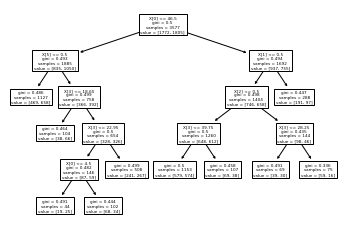

In [18]:
from sklearn import tree
tree.plot_tree(clf)
plt.show()

## Hyperparameter tuning.
- We have used the generic parameters to train decision tree, we can get better results by tuning the hyperparameters
- However we must be careful on how we cut the data.
- Data used for hyperparameter tuning should not be the same data used for reporting test results, or the results will be biased
- The data is split 3 ways, train, test and validation. We would use train and validation to determine best hyperparameters and then test set is used to report on the final result.  
- https://www.jeremyjordan.me/hyperparameter-tuning/
- Grid search is one method to find the best hyperparameters
- In the Decision tree example, we want to find the best tree depth.  Set up a 1-d grid of possible depth parameters. 
- Train on for the tree for each value in the grid, test on the validation.  Get the best results based on the validation set
- retrain the final model on the train+test, and report results on the validation

In [26]:
X_train_test, X_val, y_train_test, y_val = train_test_split(X,y, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_test,y_train_test, test_size=0.10, random_state=42)

In [27]:
n_depth_grid = range(2,10)
results = {}
results_validation = {}

for i in n_depth_grid:
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(X_train,y_train) #train on train set
    results[i] = accuracy_score(model.predict(X_test),y_test) #score on the test set
    
    model_validation = DecisionTreeClassifier(max_depth=i)
    model_validation.fit(X_train_test,y_train_test) # train on the combined train_test
    results_validation[i] = accuracy_score(model_validation.predict(X_val),y_val)
 
print(results)

{2: 0.5745721271393643, 3: 0.5501222493887531, 4: 0.5501222493887531, 5: 0.5721271393643031, 6: 0.5721271393643031, 7: 0.5647921760391198, 8: 0.5696821515892421, 9: 0.5794621026894865}


In [28]:
result_list = list(results.items())
print(result_list,"\n")
result_list.sort(key=lambda x: x[1],reverse=True)
print("best model",result_list[0])

[(2, 0.5745721271393643), (3, 0.5501222493887531), (4, 0.5501222493887531), (5, 0.5721271393643031), (6, 0.5721271393643031), (7, 0.5647921760391198), (8, 0.5696821515892421), (9, 0.5794621026894865)] 

best model (9, 0.5794621026894865)


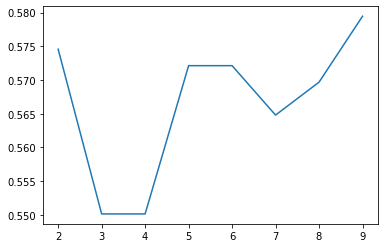

In [29]:
plt.plot(results.keys(),results.values())

## According to this plot depth =2 is the best parameter

{2: 0.5450097847358122, 3: 0.5459882583170255, 4: 0.5371819960861057, 5: 0.5459882583170255, 6: 0.5547945205479452, 7: 0.5371819960861057, 8: 0.525440313111546, 9: 0.525440313111546}


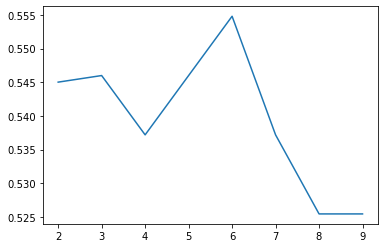

In [30]:
# validation results
print(results_validation)
plt.plot(results_validation.keys(),results_validation.values())

## Even though the validation results show depth = 2 is worse
- We should not be tempted to change which is the best model.
- Besides we could get more robust results by cross validating our results
- the numbers could easily change if we have different cut of the data

# Cross Validation
- In the last homework, you noticed that you can cheat the model metrics by cutting the data in the right way to report the best metrics.
- We can mitigate that by using cross-validation,
- See more k-fold cv here at https://scikit-learn.org/stable/modules/cross_validation.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
- We will start with a simple 3-fold cross validation

In [31]:
clf = DecisionTreeClassifier()
n_folds = 3
scores = cross_validate(clf, X_train_test, y_train_test, cv=n_folds,scoring=('accuracy','precision','recall'))
pprint.pprint(scores)
print("\n")
print("mean accuracy:",scores['test_accuracy'].mean(),
      "mean precision:",scores['test_precision'].mean(),
      "mean recall:", scores['test_recall'].mean())


{'fit_time': array([0.00857401, 0.00900197, 0.00943899]),
 'score_time': array([0.00448084, 0.00467396, 0.00397611]),
 'test_accuracy': array([0.54952311, 0.52604549, 0.530837  ]),
 'test_precision': array([0.54933726, 0.5257732 , 0.53139357]),
 'test_recall': array([0.54772394, 0.52422907, 0.51029412])}


mean accuracy: 0.5354685343615567 mean precision: 0.5355013415669232 mean recall: 0.5274157093086868


## 3-fold cross validation
- The scores have 3 elements representing the model metrics on 3 mutually exclusive cuts of the data
- see the list possible classification metrics to track, https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics



## Cross Validation with hyperparameter tuning.  
- As mentioned before, data used hyperparameter tuning should not be the same data used for reporting test results
- In previous example we trained on a single slice of the data. Now we apply to the CV to the train-test combined slice
- Cutting the data gets complicated when we have multiple folds, luckily sklearn has handy methods for this easily
- Gridsearch lets us manage multiple hyperparameters quite easily. `tuned_parameters` can have multiple parameters

In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [46]:
n_depth_grid = range(2,10)
tuned_parameters = [{"max_depth": n_depth_grid}]
clf = GridSearchCV(DecisionTreeClassifier(random_state=0), tuned_parameters, cv=n_folds , refit=True)
clf.fit(X_train_test, y_train_test)
clf.cv_results_

{'mean_fit_time': array([0.00541504, 0.00573659, 0.00483171, 0.00491563, 0.00515469,
        0.00496038, 0.00510772, 0.005548  ]),
 'std_fit_time': array([2.03133034e-04, 6.01385365e-05, 8.97647973e-05, 4.20488790e-05,
        7.46556894e-05, 1.65183799e-04, 1.24317451e-04, 4.58311500e-04]),
 'mean_score_time': array([0.00207496, 0.00190337, 0.00155791, 0.00153009, 0.00153335,
        0.00134865, 0.00140325, 0.00143774]),
 'std_score_time': array([1.23890057e-04, 1.41481468e-04, 4.34333538e-05, 3.96818740e-05,
        4.49730727e-05, 7.18251771e-06, 3.38796818e-05, 1.48852433e-04]),
 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9}],
 'split0_test_score': array([0.54292003, 0.550

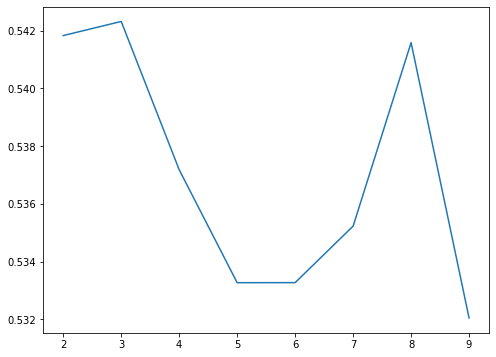

In [47]:
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]
plt.figure().set_size_inches(8, 6)
plt.plot(n_depth_grid, scores)


In [48]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=3, random_state=0)

In [49]:
# the parameters for the best model
clf.best_params_

{'max_depth': 3}

In [50]:
# the best model on the validation set
# Compare with the value above with the simpe train-test-val split
print(accuracy_score(clf.best_estimator_.predict(X_val),y_val))

0.5459882583170255


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,median_glucose
802,4970,Male,79.00,0,0,Yes,Self-employed,Rural,112.64,28.5,formerly smoked,0,0
3927,56137,Female,62.00,0,0,Yes,Private,Urban,88.32,36.3,Unknown,0,1
2337,54590,Female,21.00,0,0,No,Private,Rural,59.52,33.7,never smoked,0,1
3910,36548,Male,31.00,0,0,Yes,Govt_job,Urban,65.70,30.4,formerly smoked,0,1
1886,61171,Female,31.00,0,0,No,Private,Rural,59.63,19.9,never smoked,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,13846,Male,43.00,0,0,Yes,Govt_job,Rural,88.00,30.6,never smoked,0,1
466,1307,Female,61.00,1,0,Yes,Private,Rural,170.05,60.2,smokes,0,0
3092,31481,Female,1.16,0,0,No,children,Urban,97.28,17.8,Unknown,0,0
3772,61827,Male,80.00,0,0,Yes,Self-employed,Rural,196.08,31.0,formerly smoked,0,0


# Finally Let's use sklearn pipeline to put everything in one script
- used sklearn simple imputer to add median values to the null values.
- I added more columns to the categorical columns
- Also added more parameters to be tuned, `max_features`, `criterion`
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decision%20tree#sklearn.tree.DecisionTreeClassifier
- be careful with gridsearch, it can take hours/days to train, if you specify too many parameters and the size of the data gets large, and too many folds

In [64]:


numerical_cols =['age','hypertension','heart_disease','bmi']
categorical_cols = ['gender','ever_married','Residence_type','work_type','smoking_status']

X_pip = df.loc[X_train_test.index].copy()
y_pip = df.loc[X_train_test.index][target]

X_pip_val = df.loc[X_val.index].copy()
y_pip_val = df.loc[X_val.index][target]

numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="median")),
    ]
)

categorical_preprocessor = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, categorical_cols),
        ("numerical", numeric_preprocessor, numerical_cols),
    ]
)

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())]
)

param_grid = {
    "classifier__max_features": ["auto", "sqrt", "log2"],
    "classifier__max_depth": n_depth_grid,
    "classifier__criterion": ["gini", "entropy"],
}

grid_search = GridSearchCV(pipe, param_grid=param_grid,cv=n_folds, n_jobs=1)
set_config(display="diagram")
grid_search  # click on the diagram below to see the details of each step
grid_search.fit(X_pip,y_pip)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['gender',
                                                                          'ever_married',
                                                                          'Residence_type',
                                                                          'work_type',
                                                                          'smoking_status']),
                                                                        ('numerical',
                                                                         Pipeline(steps=[('imputation_mean',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['age',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'bmi'])])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': range(2, 10),
                         'classifier__max_features': ['auto', 'sqrt', 'log2']})

In [65]:
grid_search.cv_results_

{'mean_fit_time': array([0.01813475, 0.01227466, 0.01166908, 0.01094898, 0.01101526,
        0.01012627, 0.01026797, 0.0100836 , 0.01007167, 0.01021441,
        0.0113399 , 0.01189129, 0.01295733, 0.01292658, 0.01286038,
        0.01275102, 0.01297959, 0.01265327, 0.01317096, 0.01384163,
        0.01308211, 0.01231098, 0.01324836, 0.01311398, 0.01139704,
        0.01001366, 0.00977818, 0.01053238, 0.01078947, 0.01231845,
        0.0122714 , 0.0118889 , 0.01233768, 0.01217524, 0.01045044,
        0.01050798, 0.01063601, 0.01017245, 0.01013072, 0.01037327,
        0.0110929 , 0.01192037, 0.01315395, 0.0130926 , 0.01332601,
        0.01331949, 0.01351643, 0.01362038]),
 'std_fit_time': array([5.75086973e-03, 2.80686440e-04, 3.45310792e-04, 2.42488170e-04,
        8.56734561e-04, 2.03565383e-04, 1.18209942e-04, 2.91546140e-04,
        3.00856936e-04, 1.11570781e-04, 5.31309478e-04, 5.33261384e-04,
        1.60572509e-04, 8.20915019e-05, 8.69820193e-05, 1.55558861e-04,
        2.93492744e-0

In [66]:
grid_search.best_estimator_ # click on the diagram to see results

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'ever_married',
                                                   'Residence_type',
                                                   'work_type',
                                                   'smoking_status']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'hypertension',
                                                   'heart_disease', 'bmi'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=3, max_features='sqrt'))])

In [67]:
print(grid_search.best_score_)
print('validation results:', accuracy_score(grid_search.best_estimator_.predict(X_pip_val),y_pip_val))


0.5503873254737021
validation results: 0.541095890410959


In [68]:
import numpy as np

In [84]:
n = np.eye(3)*3
m = np.ones((3,2))

In [94]:
er =np.zeros((3,4))

In [83]:
nrow = 3
mrow = 3
ncol = 2

In [80]:
lo

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [87]:
len(m[0])

2

In [82]:
jk,lo

(array([[3., 0., 0.],
        [0., 3., 0.],
        [0., 0., 3.]]),
 array([[1., 1.],
        [1., 1.],
        [1., 1.]]))

In [95]:
for i in range(len(n)):
    for j in range(len(m)):
        for k in range(len(m[0])):
            er[i][k] += n[i][j]*m[j][k]
        

In [96]:
er

array([[114., 160.,  60.,  27.],
       [ 74.,  97.,  73.,  14.],
       [119., 157., 112.,  23.]])

In [93]:
n = np.asarray([[12,7,3],
    [4 ,5,6],
    [7 ,8,9]])

m = np.asarray([[5,8,1,2],
    [6,7,3,0],
    [4,5,9,1]])


In [186]:
dat = np.random.rand(100,3)
clusters = np.random.rand(3,3)
diff = (dat.reshape(100,3,1) - clusters.T)
eucl = np.linalg.norm(diff,axis=1)
assigns = np.argmin(eucl,axis=1)

In [187]:
assigns

array([1, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 1, 2, 0,
       1, 2, 2, 0, 2, 0, 1, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 0, 1, 2, 0, 2, 2, 2, 2, 2, 0])

In [192]:
np.linalg.norm(dat[assigns == 1],axis=0)

array([3.1220767 , 4.48264016, 4.36302134])

In [198]:
np.sqrt(np.sum(np.square(dat[assigns == 1]),axis=0))

array([3.1220767 , 4.48264016, 4.36302134])

In [144]:
clusters = np.random.rand(3,3)

In [102]:
clusters

array([[0.16507959, 0.52344671, 0.41489509],
       [0.15743497, 0.33172746, 0.15299506],
       [0.53755928, 0.02499706, 0.33480961]])

In [100]:
dat

array([[0.33204479, 0.43516397, 0.44369455],
       [0.9042919 , 0.75628974, 0.53458421],
       [0.33966381, 0.97433211, 0.84496194],
       [0.17795323, 0.98832103, 0.21305626],
       [0.9948793 , 0.77460125, 0.44929669],
       [0.28674143, 0.86186387, 0.97963637],
       [0.95804884, 0.82007487, 0.53293375],
       [0.99669825, 0.42863609, 0.03368287],
       [0.92107805, 0.14692111, 0.59484646],
       [0.54088712, 0.46380297, 0.71289165]])

In [145]:
np.linalg.norm(dat-clusters[0],axis=1)

array([0.33599801, 0.93255979, 0.75280543, 0.83545389, 0.77833421,
       0.29506926, 0.48473343, 0.80607469, 0.82118765, 0.74917436])

In [116]:
clusters

array([[0.16507959, 0.52344671, 0.41489509],
       [0.15743497, 0.33172746, 0.15299506],
       [0.53755928, 0.02499706, 0.33480961]])

In [130]:
0.43516397 - 0.5234467

-0.08828273000000003

In [147]:
dat[0]

array([0.05502861, 0.19279696, 0.811361  ])

In [152]:
dat[0]-clusters[1]

array([-0.03373735, -0.16642827,  0.23105338])

In [150]:
lop = (dat.reshape(10,3,1) - clusters.T)

In [125]:
lop[0,0]

array([ 0.1669652 , -0.19140192, -0.0828503 ])

In [167]:
ki = np.linalg.norm(lop,axis=1)

In [168]:
ki

array([[0.33599801, 0.28674421, 0.92149506],
       [0.93255979, 0.84149731, 0.02713703],
       [0.75280543, 0.81316689, 0.42447791],
       [0.83545389, 0.63720958, 0.3479381 ],
       [0.77833421, 0.59917872, 0.32494252],
       [0.29506926, 0.34576373, 0.9841572 ],
       [0.48473343, 0.15431198, 0.88937177],
       [0.80607469, 0.60143985, 0.47102397],
       [0.82118765, 0.4973728 , 0.97809944],
       [0.74917436, 0.70004912, 0.27242211]])

In [172]:
np.argmin(ki,axis=1)

array([1, 2, 2, 2, 2, 0, 1, 2, 1, 2])

In [151]:
lop

array([[[-8.65455420e-02, -3.37373494e-02, -8.50770346e-01],
        [-3.19104786e-01, -1.66428270e-01,  1.02550022e-01],
        [-5.98052515e-02,  2.31053377e-01,  3.38860519e-01]],

       [[ 7.43106712e-01,  7.95914904e-01, -2.11180926e-02],
        [-4.07662801e-01, -2.54986285e-01,  1.39920069e-02],
        [-3.88936019e-01, -9.80773905e-02,  9.72975222e-03]],

       [[ 6.94034916e-01,  7.46843109e-01, -7.01898882e-02],
        [-2.91600735e-01, -1.38924219e-01,  1.30054073e-01],
        [-7.45160958e-04,  2.90113467e-01,  3.97920610e-01]],

       [[ 4.43704439e-01,  4.96512632e-01, -3.20520365e-01],
        [-4.78819436e-01, -3.26142920e-01, -5.71646280e-02],
        [-5.21384234e-01, -2.30525606e-01, -1.22718463e-01]],

       [[ 4.64669457e-01,  5.17477649e-01, -2.99555347e-01],
        [-3.61372781e-01, -2.08696265e-01,  6.02820272e-02],
        [-5.09211304e-01, -2.18352675e-01, -1.10545533e-01]],

       [[ 5.82471991e-03,  5.86329125e-02, -7.58400084e-01],
        [ 1.82

In [119]:
np.linalg.norm(lop,axis=1)

array([[0.33737422, 0.47184891, 0.31359113],
       [0.95135205, 0.76483675, 0.80211197],
       [0.89011065, 1.05785599, 0.96979879],
       [0.89209842, 0.7654065 , 0.87677523],
       [1.03790754, 0.77357356, 0.85783637],
       [0.84050808, 1.11732279, 0.96680913],
       [1.03339888, 0.82786586, 0.88275967],
       [1.0094707 , 0.48314982, 0.71073921],
       [0.75823877, 0.71902184, 0.56910214],
       [0.51559101, 0.70067616, 0.5053925 ]])

In [136]:
clusters = np.ones((4,3))
dat = np.ones((10,3))

In [142]:
dat.reshape(10,3,1) - clusters.reshape(3,4)

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [205]:
S = np.cov(dat)

In [206]:
w,v = np.linalg.eig(np.)

In [208]:
v

array([[-0.1393136 +0.00000000e+00j,  0.02141712+0.00000000e+00j,
        -0.07140093+3.01546462e-02j, ...,  0.0468518 +1.35543759e-02j,
         0.03935417-2.25831555e-02j,  0.03935417+2.25831555e-02j],
       [-0.00622812+0.00000000e+00j, -0.13263868+0.00000000e+00j,
        -0.03196438+6.07319269e-02j, ..., -0.00886156-3.31775809e-03j,
        -0.01274851+6.60590098e-03j, -0.01274851-6.60590098e-03j],
       [ 0.03171438+0.00000000e+00j,  0.06147779+0.00000000e+00j,
         0.06362846+3.73626733e-03j, ..., -0.00648118-1.48093726e-03j,
        -0.00500743-1.48433201e-04j, -0.00500743+1.48433201e-04j],
       ...,
       [ 0.01151056+0.00000000e+00j, -0.04059069+0.00000000e+00j,
         0.00704758-1.19896160e-02j, ...,  0.4067054 -0.00000000e+00j,
         0.07273234-1.86517861e-01j,  0.07273234+1.86517861e-01j],
       [ 0.01498492+0.00000000e+00j, -0.07324392+0.00000000e+00j,
         0.0275317 +1.91317660e-02j, ...,  0.1631674 +2.20411431e-02j,
         0.08140651-2.66655568e-02j

In [209]:
np.square(S)

array([[1.01197199e-02, 3.32089790e-05, 3.17009794e-04, ...,
        1.27533083e-04, 2.64665626e-04, 3.93816310e-03],
       [3.32089790e-05, 4.00481628e-03, 9.14894742e-04, ...,
        3.58735487e-04, 1.18064950e-03, 7.78746216e-03],
       [3.17009794e-04, 9.14894742e-04, 3.48972021e-04, ...,
        5.02258869e-05, 1.88338310e-04, 3.21739464e-03],
       ...,
       [1.27533083e-04, 3.58735487e-04, 5.02258869e-05, ...,
        4.33432834e-05, 1.33176190e-04, 3.85845447e-04],
       [2.64665626e-04, 1.18064950e-03, 1.88338310e-04, ...,
        1.33176190e-04, 4.15414894e-04, 1.49147361e-03],
       [3.93816310e-03, 7.78746216e-03, 3.21739464e-03, ...,
        3.85845447e-04, 1.49147361e-03, 2.99752616e-02]])

In [243]:
dist

array([0., 0., 0., 0.])

In [244]:
dist = np.zeros((4,4))
dat = np.random.rand(4,3)

In [238]:
ack = np.linalg.norm(dat[0] - dat,axis=1)
np.where(ack==0,100,ack)

array([100.        ,   1.11385891,   0.96594164,   0.81880585])

In [247]:
for i in range(4):
    dist[i] = np.linalg.norm(dat[i]-dat,axis=1)

In [254]:
yuck = np.where(dist ==0 ,np.inf,dist)

In [253]:
dist

array([[0.        , 0.87436771, 0.61564332, 0.66985081],
       [0.87436771, 0.        , 1.0867372 , 0.88252131],
       [0.61564332, 1.0867372 , 0.        , 0.65490257],
       [0.66985081, 0.88252131, 0.65490257, 0.        ]])

In [257]:
yuck

array([[       inf, 0.87436771, 0.61564332, 0.66985081],
       [0.87436771,        inf, 1.0867372 , 0.88252131],
       [0.61564332, 1.0867372 ,        inf, 0.65490257],
       [0.66985081, 0.88252131, 0.65490257,        inf]])

In [258]:
uu = np.argsort(yuck,axis=1)

In [260]:
uu

array([[2, 3, 1, 0],
       [0, 3, 2, 1],
       [0, 3, 1, 2],
       [2, 0, 1, 3]])

In [259]:
uu[:,:2]

array([[2, 3],
       [0, 3],
       [0, 3],
       [2, 0]])

In [228]:
hah = np.linalg.norm(jk,axis=1)

In [229]:
hah

array([[0.        , 1.11385891, 0.96594164, 0.81880585],
       [1.11385891, 0.        , 0.27682387, 0.8461219 ],
       [0.96594164, 0.27682387, 0.        , 0.77918893],
       [0.81880585, 0.8461219 , 0.77918893, 0.        ]])

In [261]:
bike = pd.read_csv('2017-capitalbikeshare-tripdata/2017Q1-capitalbikeshare-tripdata.csv')

In [263]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646510 entries, 0 to 646509
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Duration              646510 non-null  int64 
 1   Start date            646510 non-null  object
 2   End date              646510 non-null  object
 3   Start station number  646510 non-null  int64 
 4   Start station         646510 non-null  object
 5   End station number    646510 non-null  int64 
 6   End station           646510 non-null  object
 7   Bike number           646510 non-null  object
 8   Member type           646510 non-null  object
dtypes: int64(3), object(6)
memory usage: 44.4+ MB


In [270]:
bike['state_date'] = pd.to_datetime(bike['Start date'])
bike['end_date'] = pd.to_datetime(bike['End date'])

In [273]:
bike['Duration'].cumsum()

0               221
1              1897
2              3253
3              4580
4              6216
            ...    
646505    653260813
646506    653261070
646507    653261493
646508    653262541
646509    653262764
Name: Duration, Length: 646510, dtype: int64

In [274]:
bike.sort_values(['state_date']).groupby('Start station number')['Duration'].cumsum()

0             221
1            1676
2            1356
3            2683
4            3312
           ...   
646505    1617983
646506    2527835
646507    3032972
646508    3522575
646509    3496678
Name: Duration, Length: 646510, dtype: int64

In [284]:
bike['rank'] = bike.groupby('Start station')['Duration'].transform('rank')

In [285]:
bike.

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type,state_date,end_date,rank
0,221,2017-01-01 00:00:41,2017-01-01 00:04:23,31634,3rd & Tingey St SE,31208,M St & New Jersey Ave SE,W00869,Member,2017-01-01 00:00:41,2017-01-01 00:04:23,170.5
1,1676,2017-01-01 00:06:53,2017-01-01 00:34:49,31258,Lincoln Memorial,31270,8th & D St NW,W00894,Casual,2017-01-01 00:06:53,2017-01-01 00:34:49,4354.0
2,1356,2017-01-01 00:07:10,2017-01-01 00:29:47,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31222,New York Ave & 15th St NW,W21945,Casual,2017-01-01 00:07:10,2017-01-01 00:29:47,1706.0
3,1327,2017-01-01 00:07:22,2017-01-01 00:29:30,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31222,New York Ave & 15th St NW,W20012,Casual,2017-01-01 00:07:22,2017-01-01 00:29:30,1659.0
4,1636,2017-01-01 00:07:36,2017-01-01 00:34:52,31258,Lincoln Memorial,31270,8th & D St NW,W22786,Casual,2017-01-01 00:07:36,2017-01-01 00:34:52,4207.0
...,...,...,...,...,...,...,...,...,...,...,...,...
646505,687,2017-03-31 23:57:10,2017-04-01 00:08:37,31404,9th & Upshur St NW,31281,8th & O St NW,W01307,Member,2017-03-31 23:57:10,2017-04-01 00:08:37,554.5
646506,257,2017-03-31 23:57:55,2017-04-01 00:02:13,31602,Park Rd & Holmead Pl NW,31400,Georgia & New Hampshire Ave NW,W21760,Member,2017-03-31 23:57:55,2017-04-01 00:02:13,405.0
646507,423,2017-03-31 23:58:34,2017-04-01 00:05:38,31627,3rd & M St NE,31614,11th & H St NE,W20773,Member,2017-03-31 23:58:34,2017-04-01 00:05:38,1354.5
646508,1048,2017-03-31 23:59:33,2017-04-01 00:17:02,31213,17th & K St NW,31606,Potomac & Pennsylvania Ave SE,W20784,Member,2017-03-31 23:59:33,2017-04-01 00:17:02,3478.5


In [297]:
hmm = bike.groupby('Start station')['Duration'].nlargest(5).reset_index().drop(columns=["level_1"])

In [301]:
bike.merge(hmm,on=['Start station'],how='left')

,Duration_x,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type,state_date,end_date,rank,Duration_y
0,221,2017-01-01 00:00:41,2017-01-01 00:04:23,31634,3rd & Tingey St SE,31208,M St & New Jersey Ave SE,W00869,Member,2017-01-01 00:00:41,2017-01-01 00:04:23,170.5,32630
1,221,2017-01-01 00:00:41,2017-01-01 00:04:23,31634,3rd & Tingey St SE,31208,M St & New Jersey Ave SE,W00869,Member,2017-01-01 00:00:41,2017-01-01 00:04:23,170.5,13360
2,221,2017-01-01 00:00:41,2017-01-01 00:04:23,31634,3rd & Tingey St SE,31208,M St & New Jersey Ave SE,W00869,Member,2017-01-01 00:00:41,2017-01-01 00:04:23,170.5,13301
3,221,2017-01-01 00:00:41,2017-01-01 00:04:23,31634,3rd & Tingey St SE,31208,M St & New Jersey Ave SE,W00869,Member,2017-01-01 00:00:41,2017-01-01 00:04:23,170.5,11764
4,221,2017-01-01 00:00:41,2017-01-01 00:04:23,31634,3rd & Tingey St SE,31208,M St & New Jersey Ave SE,W00869,Member,2017-01-01 00:00:41,2017-01-01 00:04:23,170.5,10758
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3232527,223,2017-03-31 23:59:43,2017-04-01 00:03:26,31104,Adams Mill & Columbia Rd NW,31103,16th & Harvard St NW,W20825,Member,2017-03-31 23:59:43,2017-04-01 00:03:26,887.5,69626
3232528,223,2017-03-31 23:59:43,2017-04-01 00:03:26,31104,Adams Mill & Columbia Rd NW,31103,16th & Harvard St NW,W20825,Member,2017-03-31 23:59:43,2017-04-01 00:03:26,887.5,54022
3232529,223,2017-03-31 23:59:43,2017-04-01 00:03:26,31104,Adams Mill & Columbia Rd NW,31103,16th & Harvard St NW,W20825,Member,2017-03-31 23:59:43,2017-04-01 00:03:26,887.5,53974
3232530,223,2017-03-31 23:59:43,2017-04-01 00:03:26,31104,Adams Mill & Columbia Rd NW,31103,16th & Harvard St NW,W20825,Member,2017-03-31 23:59:43,2017-04-01 00:03:26,887.5,52448


In [298]:
bike

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type,state_date,end_date,rank
0,221,2017-01-01 00:00:41,2017-01-01 00:04:23,31634,3rd & Tingey St SE,31208,M St & New Jersey Ave SE,W00869,Member,2017-01-01 00:00:41,2017-01-01 00:04:23,170.5
1,1676,2017-01-01 00:06:53,2017-01-01 00:34:49,31258,Lincoln Memorial,31270,8th & D St NW,W00894,Casual,2017-01-01 00:06:53,2017-01-01 00:34:49,4354.0
2,1356,2017-01-01 00:07:10,2017-01-01 00:29:47,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31222,New York Ave & 15th St NW,W21945,Casual,2017-01-01 00:07:10,2017-01-01 00:29:47,1706.0
3,1327,2017-01-01 00:07:22,2017-01-01 00:29:30,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31222,New York Ave & 15th St NW,W20012,Casual,2017-01-01 00:07:22,2017-01-01 00:29:30,1659.0
4,1636,2017-01-01 00:07:36,2017-01-01 00:34:52,31258,Lincoln Memorial,31270,8th & D St NW,W22786,Casual,2017-01-01 00:07:36,2017-01-01 00:34:52,4207.0
...,...,...,...,...,...,...,...,...,...,...,...,...
646505,687,2017-03-31 23:57:10,2017-04-01 00:08:37,31404,9th & Upshur St NW,31281,8th & O St NW,W01307,Member,2017-03-31 23:57:10,2017-04-01 00:08:37,554.5
646506,257,2017-03-31 23:57:55,2017-04-01 00:02:13,31602,Park Rd & Holmead Pl NW,31400,Georgia & New Hampshire Ave NW,W21760,Member,2017-03-31 23:57:55,2017-04-01 00:02:13,405.0
646507,423,2017-03-31 23:58:34,2017-04-01 00:05:38,31627,3rd & M St NE,31614,11th & H St NE,W20773,Member,2017-03-31 23:58:34,2017-04-01 00:05:38,1354.5
646508,1048,2017-03-31 23:59:33,2017-04-01 00:17:02,31213,17th & K St NW,31606,Potomac & Pennsylvania Ave SE,W20784,Member,2017-03-31 23:59:33,2017-04-01 00:17:02,3478.5


In [317]:
weight = np.eye(4)

In [315]:
weight

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [302]:
dat

array([[0.4191041 , 0.0737923 , 0.33286573],
       [0.98857013, 0.30873436, 0.95337324],
       [0.3779926 , 0.65072216, 0.1219665 ],
       [0.9643742 , 0.36324441, 0.07286937]])

In [318]:
weight.T.dot(dat)

array([[0.4191041 , 0.0737923 , 0.33286573],
       [0.98857013, 0.30873436, 0.95337324],
       [0.3779926 , 0.65072216, 0.1219665 ],
       [0.9643742 , 0.36324441, 0.07286937]])